# Laboratorio de Control Térmico - TempLABUdeA
## Modelado del Sistema - Fase 1

In [1]:

# Parámetros identificados
Kp = 0.3593          # Ganancia del proceso
tm = 10.3349         # Tiempo muerto (s)
tau = 171.7428       # Constante de tiempo (s)

print(f"Modelo FOPDT identificado:")
print(f"G(s) = {Kp} * exp(-{tm} * s) / ({tau} * s + 1)")

Modelo FOPDT identificado:
G(s) = 0.3593 * exp(-10.3349 * s) / (171.7428 * s + 1)


## Función de Transferencia Simbólica

In [2]:
import sympy as sp

s = sp.symbols('s')
Kp_val = 0.3593
tm_val = 10.3349
tau_val = 171.7428

# Modelo simbólico
G_s = Kp_val * sp.exp(-tm_val * s) / (tau_val * s + 1)
G_s.simplify()

0.3593*exp(-10.3349*s)/(171.7428*s + 1)


### Interpretación:
El modelo FOPDT describe el comportamiento dinámico de la temperatura frente a cambios en la potencia de calefacción con:
- Una **ganancia de proceso** $ K_p = 0.3593 $
- Un **tiempo muerto** $ \theta_p = 10.33\,s $
- Una **constante de tiempo** $\tau_p = 171.74\,s $

Este modelo será utilizado para diseñar el controlador PID en la siguiente fase.
## Diseño de PID mediante Ziegler-Nichols - Fase 2
- Encontrando parametros del PID
- $ K_C =(1.2 * \tau_p) / (K_p * \theta_p) $   
- $ Ti = 2 * \theta_p $
- $ Td = 0.5 * \theta_p $

In [6]:
Kc = (1.2 * tau_val) / (Kp_val * tm)
Ti = 2 * tm
Td = 0.5 * tm
print("Parámetros del controlador PID calculados:")
print(f"Kc = {Kc:.4f}")
print(f"Ti = {Ti:.4f} s")
print(f"Td = {Td:.4f} s")


Parámetros del controlador PID calculados:
Kc = 55.5004
Ti = 20.6698 s
Td = 5.1674 s


### Implementacion  de simulacion

![Simulacio.png](https://raw.githubusercontent.com/jbcgames/Lab_5_Control/refs/heads/main/Simulacio.png)
![Resultados.png](https://raw.githubusercontent.com/jbcgames/Lab_5_Control/refs/heads/main/Resultados.png)

- Periodo $P_u = 37.859s$
- $K_p= 104$

- $K_p =0,6K_u$
- $T_i = 0,5P_u$,
- $T_d = 0,125P_u$

In [8]:
Kp=104
Pu=37.859
Ku=Kp*0.6
Ti=0.5*Pu
Td=0.125*Pu
print("Parámetros del controlador PID calculados:") 
print(f"Kc = {Ku:.4f}")
print(f"Ti = {Ti:.4f} s")
print(f"Td = {Td:.4f} s")


Parámetros del controlador PID calculados:
Kc = 62.4000
Ti = 18.9295 s
Td = 4.7324 s


### Implementacion del sistema

$$ 
P=K_c

 $$
  $$
  I=K_c/T_i

 $$
  $$
  D=K_c*T_d
 $$

In [9]:
P=Kc
I=Kc/Ti
D=Kc*Td
print("Parámetros del controlador PID calculados:") 
print(f"Kp = {P:.4f}")
print(f"Ki = {I:.4f}")
print(f"Kd = {D:.4f}")

Parámetros del controlador PID calculados:
Kp = 55.5004
Ki = 2.9320
Kd = 262.6488


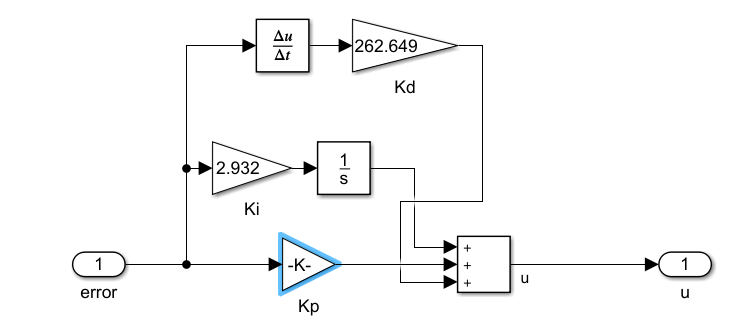